## ЛР 3 - Классификация шахматных фигур на основе CNN

In [1]:
import os
import random
from pathlib import Path

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

torch.set_num_threads(1)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


g = torch.Generator()
g.manual_seed(SEED)

DEVICE

device(type='cuda')

In [2]:
# Kaggle требует API token (kaggle.json).
# ~/.kaggle/kaggle.json либо ./kaggle.json рядом с ноутбуком

import sys
import subprocess
import zipfile

DATA_DIR = Path("data")


def _ensure_kaggle_token() -> Path:
    kaggle_json = Path.home() / ".kaggle" / "kaggle.json"
    if kaggle_json.exists():
        return kaggle_json

    local = Path("kaggle.json")
    if not local.exists():
        raise FileNotFoundError(
            "Не найден kaggle.json.\n"
        )

    kaggle_json.parent.mkdir(parents=True, exist_ok=True)
    kaggle_json.write_bytes(local.read_bytes())
    try:
        os.chmod(kaggle_json, 0o600)
    except PermissionError:
        pass
    return kaggle_json


def _download_and_unzip(dataset: str, data_dir: Path):
    _ensure_kaggle_token()
    data_dir.mkdir(parents=True, exist_ok=True)

    try:
        subprocess.check_call(
            [
                "kaggle",
                "datasets",
                "download",
                "-d",
                dataset,
                "-p",
                str(data_dir),
                "--force",
            ],
            timeout=300
        )
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired) as e:
        print(e)
        raise RuntimeError("Автоскачивание не удалось") from e
        
    zips = sorted(data_dir.glob("*.zip"), key=lambda p: p.stat().st_mtime, reverse=True)
    if zips:
        with zipfile.ZipFile(zips[0], "r") as zf:
            zf.extractall(data_dir)
        print(f"Распаковано")


def _find_classes_root(data_dir: Path, expected_classes=None) -> Path:
    if expected_classes is None:
        expected_classes = ["Bishop", "King", "Knight", "Pawn", "Queen", "Rook"]

    candidates = []
    for root in data_dir.rglob("*"):
        if not root.is_dir():
            continue
        subdirs = [d.name for d in root.iterdir() if d.is_dir()]
        matches = sum(1 for cls in expected_classes if cls in subdirs)
        if matches >= 4:
            candidates.append((root, matches))

    if candidates:
        best = max(candidates, key=lambda x: x[1])
        return best[0]

    raise FileNotFoundError(
        f"Не найдена папка с классами в {data_dir.resolve()}.\n"
        f"Ожидаемая структура: {data_dir}/Chess/Bishop/, .../King/, и т.д."
    )

DATASET_1 = "niteshfre/chessman-image-dataset"

possible_roots = [
    DATA_DIR / "Chess",
    DATA_DIR / "chessman-image-dataset" / "Chess",
    DATA_DIR / "chessman-image-dataset",
]

DATA_ROOT_1 = None
for candidate in possible_roots:
    if candidate.exists() and any(candidate.rglob("Bishop")):
        DATA_ROOT_1 = _find_classes_root(candidate.parent if candidate.name == "Chess" else candidate)
        print(f"✓ Датасет найден: {DATA_ROOT_1.resolve()}")
        break

if DATA_ROOT_1 is None:
    print(f"Скачиваем {DATASET_1}...")
    try:
        _download_and_unzip(DATASET_1, DATA_DIR)
        
        for candidate in [DATA_DIR / "Chess", DATA_DIR / "chessman-image-dataset", DATA_DIR]:
            try:
                DATA_ROOT_1 = _find_classes_root(candidate)
                print(f"Датасет готов: {DATA_ROOT_1.resolve()}")
                break
            except FileNotFoundError:
                continue
        
        if DATA_ROOT_1 is None:
            raise FileNotFoundError(f"Не найдена папка с классами в {DATA_DIR.resolve()}")
            
    except RuntimeError as e:
        print(f"\nСкачай датасет вручную: https://www.kaggle.com/datasets/{DATASET_1}")
        raise
        
probe = datasets.ImageFolder(DATA_ROOT_1)
classes = probe.classes

print(f"\nДатасет загружен: {len(probe)} изображений, {len(classes)} классов")
print(f"Classes: {classes}")

# Статистика по классам
counts = {cls: 0 for cls in classes}
for _, y in probe.samples:
    counts[classes[y]] += 1

for cls, cnt in counts.items():
    print(f"  {cls:10s}: {cnt:4d}")

Скачиваем niteshfre/chessman-image-dataset...
Dataset URL: https://www.kaggle.com/datasets/niteshfre/chessman-image-dataset
License(s): other


 99%|█████████▉| 57.0M/57.6M [00:11<00:00, 5.44MB/s]


Распаковано
Датасет готов: /home/jovyan/work/data/сhessman-image-dataset/Chess

Датасет загружен: 553 изображений, 6 классов
Classes: ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
  Bishop    :   86
  King      :   76
  Knight    :  106
  Pawn      :  106
  Queen     :   77
  Rook      :  102


100%|██████████| 57.6M/57.6M [00:11<00:00, 5.17MB/s]


In [3]:
IMG_SIZE = 224

BATCH_SIZE = 16
VAL_SIZE = 0.2

NUM_WORKERS = 0
PIN_MEMORY = torch.cuda.is_available()

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Stratified split по классам
labels = np.array([y for _, y in probe.samples])
idx = np.arange(len(labels))

train_idx, val_idx = train_test_split(
    idx,
    test_size=VAL_SIZE,
    random_state=SEED,
    stratify=labels,
)

train_ds = Subset(datasets.ImageFolder(DATA_ROOT_1, transform=train_tfms), train_idx)
val_ds = Subset(datasets.ImageFolder(DATA_ROOT_1, transform=val_tfms), val_idx)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g,
)

num_classes = len(probe.classes)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Classes: {num_classes}")

Train: 442, Val: 111, Classes: 6


In [4]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW([
    {'params': model.layer3.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4},
    {'params': model.layer4.parameters(), 'lr': 1e-4, 'weight_decay': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3, 'weight_decay': 1e-4},
])

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3
)

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
def _run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_y_true = []
    all_y_pred = []

    for x, y in tqdm(loader, leave=False):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        if is_train:
            optimizer.zero_grad(set_to_none=True)

        with torch.set_grad_enabled(is_train):
            logits = model(x)
            loss = criterion(logits, y)

            if is_train:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)

        all_y_true.append(y.detach().cpu().numpy())
        all_y_pred.append(preds.detach().cpu().numpy())

    y_true = np.concatenate(all_y_true)
    y_pred = np.concatenate(all_y_pred)

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")

    return avg_loss, acc, f1


EPOCHS = 25
PATIENCE = 7
SAVE_PATH = Path("best_resnet18_chess.pth")

history = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": [],
}

best_val_f1 = 0.0
patience_left = PATIENCE

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc, train_f1 = _run_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc, val_f1 = _run_epoch(model, val_loader, optimizer=None)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    scheduler.step(val_f1)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"train: loss={train_loss:.4f} acc={train_acc:.3f} f1={train_f1:.3f} | "
        f"val: loss={val_loss:.4f} acc={val_acc:.3f} f1={val_f1:.3f}"
    )

    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        patience_left = PATIENCE
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "classes": classes,
                "img_size": IMG_SIZE,
                "mean": (0.485, 0.456, 0.406),
                "std": (0.229, 0.224, 0.225),
            },
            SAVE_PATH,
        )
        print(f"  Saved best model (F1={val_f1:.4f}) to {SAVE_PATH}")
    else:
        patience_left -= 1
        if patience_left <= 0:
            print("Early stopping: validation F1 stopped improving")
            break

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 01/25 | train: loss=1.5238 acc=0.394 f1=0.346 | val: loss=0.8671 acc=0.703 f1=0.655
  Saved best model (F1=0.6551) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 02/25 | train: loss=0.7236 acc=0.733 f1=0.708 | val: loss=0.5730 acc=0.775 f1=0.711
  Saved best model (F1=0.7107) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 03/25 | train: loss=0.4518 acc=0.848 f1=0.832 | val: loss=0.4909 acc=0.829 f1=0.796
  Saved best model (F1=0.7955) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 04/25 | train: loss=0.2929 acc=0.900 f1=0.890 | val: loss=0.5043 acc=0.829 f1=0.811
  Saved best model (F1=0.8113) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 05/25 | train: loss=0.2483 acc=0.916 f1=0.908 | val: loss=0.4227 acc=0.829 f1=0.809


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 06/25 | train: loss=0.2394 acc=0.928 f1=0.919 | val: loss=0.4663 acc=0.820 f1=0.795


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 07/25 | train: loss=0.1516 acc=0.952 f1=0.949 | val: loss=0.5251 acc=0.838 f1=0.821
  Saved best model (F1=0.8210) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 08/25 | train: loss=0.1436 acc=0.950 f1=0.947 | val: loss=0.3990 acc=0.856 f1=0.843
  Saved best model (F1=0.8425) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 09/25 | train: loss=0.1330 acc=0.939 f1=0.932 | val: loss=0.4780 acc=0.856 f1=0.839


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10/25 | train: loss=0.1911 acc=0.941 f1=0.936 | val: loss=0.5291 acc=0.847 f1=0.814


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11/25 | train: loss=0.1098 acc=0.964 f1=0.960 | val: loss=0.4234 acc=0.883 f1=0.869
  Saved best model (F1=0.8688) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12/25 | train: loss=0.1253 acc=0.955 f1=0.950 | val: loss=0.5567 acc=0.856 f1=0.836


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13/25 | train: loss=0.0554 acc=0.986 f1=0.985 | val: loss=0.5223 acc=0.856 f1=0.839


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 14/25 | train: loss=0.1040 acc=0.971 f1=0.968 | val: loss=0.4835 acc=0.892 f1=0.884
  Saved best model (F1=0.8844) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 15/25 | train: loss=0.0539 acc=0.977 f1=0.976 | val: loss=0.5148 acc=0.865 f1=0.852


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 16/25 | train: loss=0.1174 acc=0.971 f1=0.970 | val: loss=0.5255 acc=0.874 f1=0.861


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 17/25 | train: loss=0.1141 acc=0.968 f1=0.966 | val: loss=0.5782 acc=0.829 f1=0.813


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 18/25 | train: loss=0.0525 acc=0.982 f1=0.981 | val: loss=0.5225 acc=0.883 f1=0.868


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 19/25 | train: loss=0.1031 acc=0.971 f1=0.969 | val: loss=0.4641 acc=0.883 f1=0.869


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 20/25 | train: loss=0.0632 acc=0.977 f1=0.975 | val: loss=0.3827 acc=0.919 f1=0.912
  Saved best model (F1=0.9121) to best_resnet18_chess.pth


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 21/25 | train: loss=0.0626 acc=0.980 f1=0.978 | val: loss=0.4004 acc=0.901 f1=0.895


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 22/25 | train: loss=0.0288 acc=0.989 f1=0.988 | val: loss=0.4765 acc=0.910 f1=0.901


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 23/25 | train: loss=0.0495 acc=0.986 f1=0.986 | val: loss=0.4750 acc=0.892 f1=0.879


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 24/25 | train: loss=0.0396 acc=0.989 f1=0.988 | val: loss=0.5965 acc=0.874 f1=0.862


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 25/25 | train: loss=0.0367 acc=0.989 f1=0.988 | val: loss=0.5150 acc=0.883 f1=0.873


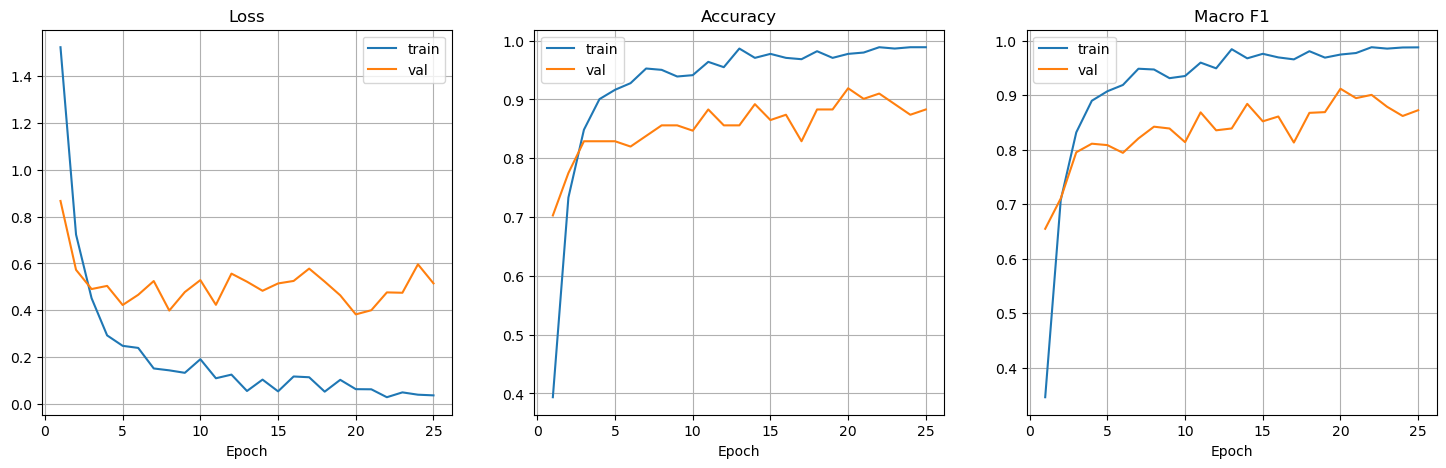

In [6]:
def plot_history(history):
    epochs = np.arange(1, len(history["train_loss"]) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(epochs, history["train_loss"], label="train")
    axes[0].plot(epochs, history["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(epochs, history["train_acc"], label="train")
    axes[1].plot(epochs, history["val_acc"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].grid(True)
    axes[1].legend()

    axes[2].plot(epochs, history["train_f1"], label="train")
    axes[2].plot(epochs, history["val_f1"], label="val")
    axes[2].set_title("Macro F1")
    axes[2].set_xlabel("Epoch")
    axes[2].grid(True)
    axes[2].legend()

    plt.show()


plot_history(history)

  0%|          | 0/7 [00:00<?, ?it/s]

Val accuracy: 0.9189
Val balanced accuracy: 0.9097
Val macro F1: 0.9121

Classification report:

              precision    recall  f1-score   support

      Bishop       0.92      0.71      0.80        17
        King       1.00      0.80      0.89        15
      Knight       1.00      1.00      1.00        21
        Pawn       0.80      0.95      0.87        21
       Queen       0.84      1.00      0.91        16
        Rook       1.00      1.00      1.00        21

    accuracy                           0.92       111
   macro avg       0.93      0.91      0.91       111
weighted avg       0.93      0.92      0.92       111



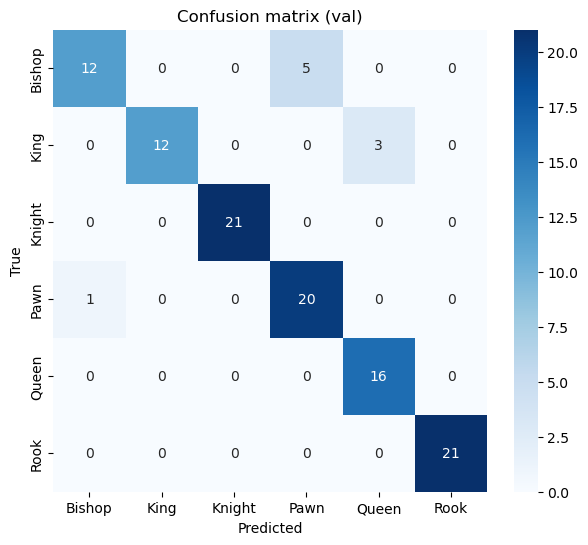

In [7]:
ckpt = torch.load(SAVE_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()

@torch.no_grad()
def predict_all(loader):
    y_true_all = []
    y_pred_all = []
    for x, y in tqdm(loader, leave=False):
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred_all.append(preds)
        y_true_all.append(y.numpy())
    return np.concatenate(y_true_all), np.concatenate(y_pred_all)


y_true, y_pred = predict_all(val_loader)

acc = accuracy_score(y_true, y_pred)
balanced_acc = balanced_accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average="macro")

print(f"Val accuracy: {acc:.4f}")
print(f"Val balanced accuracy: {balanced_acc:.4f}")
print(f"Val macro F1: {macro_f1:.4f}")

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion matrix (val)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

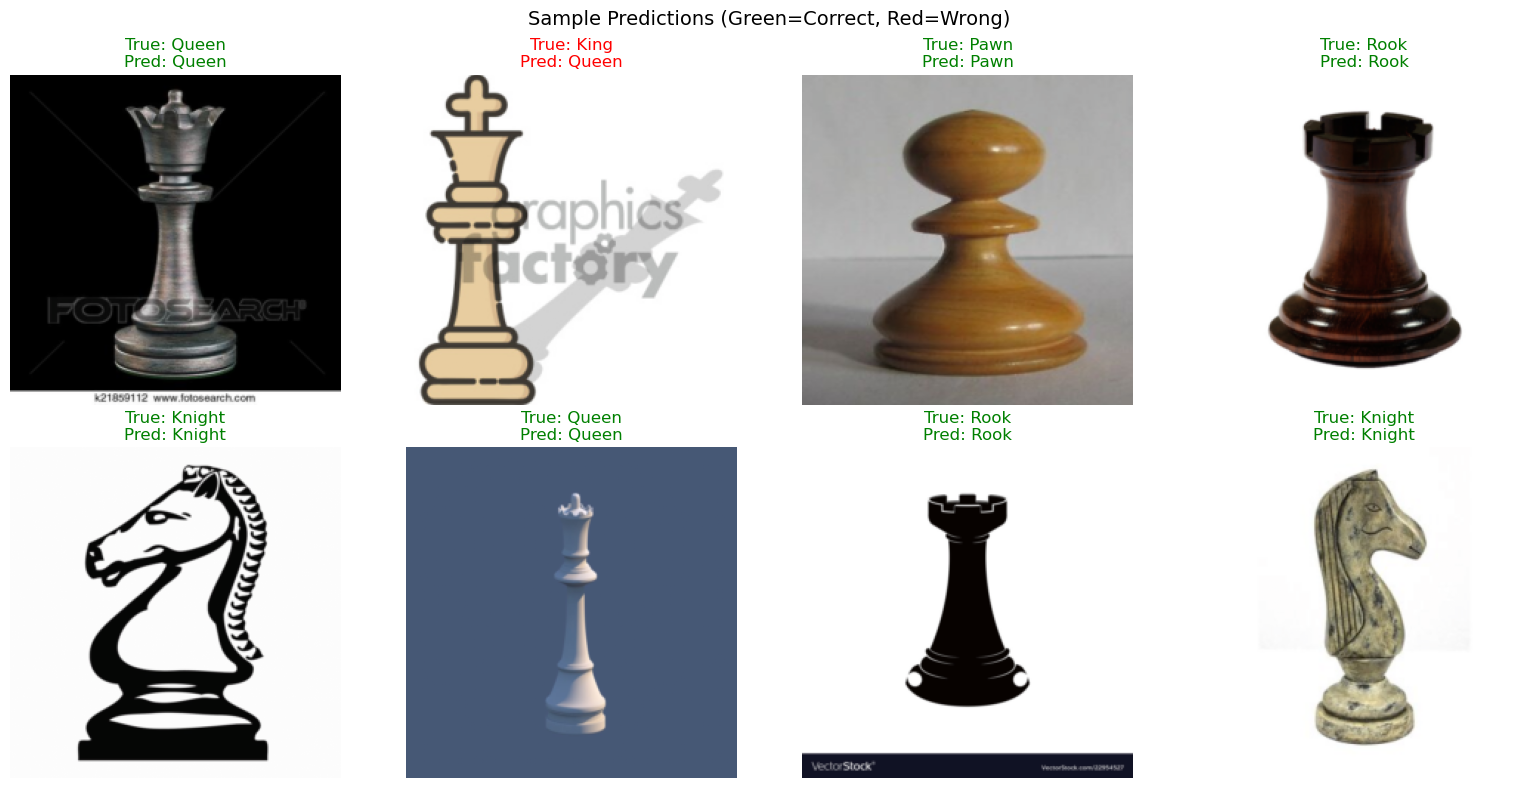

In [8]:
def show_predictions(model, dataset, classes, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    indices = random.sample(range(len(dataset)), n)
    
    inv_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
    ])
    
    model.eval()
    for ax, idx in zip(axes.flat, indices):
        img, true_label = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(DEVICE)).argmax(1).item()
        
        img_display = inv_normalize(img).permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img_display)
        color = 'green' if pred == true_label else 'red'
        ax.set_title(f"True: {classes[true_label]}\nPred: {classes[pred]}", color=color, fontsize=12)
        ax.axis('off')
    
    plt.suptitle("Sample Predictions (Green=Correct, Red=Wrong)", fontsize=14)
    plt.tight_layout()
    plt.show()


show_predictions(model, val_ds, classes)


### Оценка на тестовом наборе

  0%|          | 0/7 [00:00<?, ?it/s]

Test (custom) accuracy: 0.7245
Test (custom) balanced accuracy: 0.7342
Test (custom) macro F1: 0.7166

Classification report:

              precision    recall  f1-score   support

      Bishop       0.93      0.72      0.81        18
        King       0.56      0.69      0.62        13
      Knight       1.00      0.47      0.64        15
        Pawn       0.75      1.00      0.86        15
       Queen       0.79      0.52      0.63        21
        Rook       0.59      1.00      0.74        16

    accuracy                           0.72        98
   macro avg       0.77      0.73      0.72        98
weighted avg       0.78      0.72      0.72        98



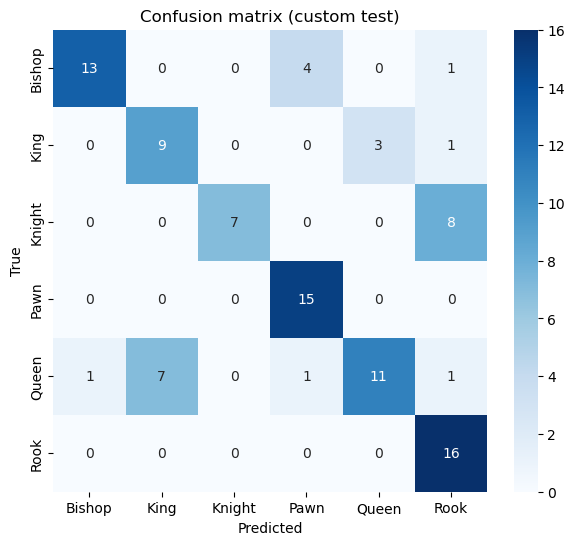

In [9]:
TEST_CUSTOM_ROOT = Path("test_custom")

if not TEST_CUSTOM_ROOT.exists():
    print(
        f"Не найден {TEST_CUSTOM_ROOT.resolve()}.\n")
else:
    test_ds = datasets.ImageFolder(TEST_CUSTOM_ROOT, transform=val_tfms)
    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        worker_init_fn=seed_worker,
        generator=g,
    )

    y_true_raw, y_pred = predict_all(test_loader)
    
    train_class_to_idx = {name: i for i, name in enumerate(classes)}
    
    y_true = np.array([train_class_to_idx[test_ds.classes[i]] for i in y_true_raw])
    
    acc_test = accuracy_score(y_true, y_pred)
    balanced_acc_test = balanced_accuracy_score(y_true, y_pred)
    macro_f1_test = f1_score(y_true, y_pred, average="macro")

    print(f"Test (custom) accuracy: {acc_test:.4f}")
    print(f"Test (custom) balanced accuracy: {balanced_acc_test:.4f}")
    print(f"Test (custom) macro F1: {macro_f1_test:.4f}")

    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=classes, labels=list(range(len(classes)))))

    cm_t = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_t, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion matrix (custom test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()